In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14

In [2]:
class boltzmanmachine:
    
    def __init__(self, N, L, M, sigma, De, vmin):
        self.w = sigma * np.random.randn(L,M)
        self.a = sigma * np.random.randn(L)
        self.b = b = np.zeros(M)
        
        self.DE = De
        self.N = int(N)
        self.L = int(L)
        self.M = int(M)
        self.vmin=vmin
        
        self.v_data, self.v_model = None, None
        self.h_data, self.h_model = None, None
        self.vh_data,self.vh_model= None, None
        
        '''
        self.csi1 = np.array([1,0,0,0])    
        self.csi2 = np.array([0,1,0,0])   
        self.csi3 = np.array([0,0,1,0])    
        self.csi4 = np.array([0,0,0,1])  
        
        '''
        self.csi1 = np.array([1,-1,-1,-1])    
        self.csi2 = np.array([-1,1,-1,-1])   
        self.csi3 = np.array([-1,-1,1,-1])    
        self.csi4 = np.array([-1,-1,-1,1]) 
        
        
        self.csi = [self.csi1, self.csi2, self.csi3, self.csi4]
        
        #algotithm variables
        self.sa_t0 = 0
        self.sb_t0 = 0
        self.sw_t0 = 0
        
        
        
    def init_avg(self):
        self.v_data, self.v_model = np.zeros(self.L),np.zeros(self.L)
        self.h_data, self.h_model = np.zeros(self.M),np.zeros(self.M)
        self.vh_data,self.vh_model= np.zeros((self.L,self.M)),np.zeros((self.L,self.M))
        
        
        
    def positive(self, v_in, Amp=1):
        act = np.dot(v_in, self.w) + self.b      
        #print(act)
        argument=np.exp(-Amp*self.DE*act)
        prob = 1. / (1. + argument)
        n = np.shape(act)
        h = np.full(n, self.vmin, dtype=int) # a list on -1's or 0's
        h[np.random.random_sample(n) < prob] = 1
        
        return h
    
    def neg(self, h_in, Amp=1):
        act = np.dot(h_in, self.w.T) + self.a      
        #print(act)
        prob = 1. / (1. + np.exp(-Amp*self.DE*act))
        n = np.shape(act)
        vf = np.full(n, self.vmin, dtype=int) # a list on -1's or 0's
        vf[np.random.random_sample(n) < prob] = 1
        
        return vf
    
    
    def negative(self, h_in, Amp=1):
        
        weigths = np.reshape(np.dot(h_in, self.w.T) + self.a, (5,4) ) 
        #print(weigths)
        E1 = np.dot(weigths, self.csi1) #array of length 5, the number of amminoacids
        E2 = np.dot(weigths, self.csi2)
        E3 = np.dot(weigths, self.csi3)
        E4 = np.dot(weigths, self.csi4)
        
        #print(E1)
        #print(E2)
        #print(E3)
        #print(E4)

        Z = np.exp(-E1) + np.exp(-E2) + np.exp(-E3) + np.exp(-E4) #partition function for each amminoacid
        
        p1 = np.exp(-E1)/Z 
        p2 = np.exp(-E2)/Z
        p3 = np.exp(-E3)/Z
        p4 = np.exp(-E4)/Z
        
        
        
        p = np.reshape(np.concatenate((p1, p2, p3, p4)), (4, 5))      
        #print(p1)
        
        cum = np.cumsum(p, axis=0) #(4x5) containing the comulatives  
        r = np.random.random(size=5)        
        
        mask = cum < r    
        indx = []    
        
        for i in range(mask.shape[1]):
            __, index = np.unique(mask[:, i], return_index=True)
            indx.append(index[0])
            
        vf=np.concatenate((self.csi[indx[0]], self.csi[indx[1]], self.csi[indx[2]], self.csi[indx[3]], self.csi[indx[4]]))
        #vf[vf==0]=-1
        #print(vf)
        return vf
        
    
    def update_vh(self, v_k, vf, h, hf):
        self.v_data  += v_k
        self.v_model += vf
        self.h_data  += h
        self.h_model += hf
        self.vh_data += np.outer(v_k.T,h)
        self.vh_model+= np.outer(vf.T,hf)
    
    def SDG(self, l_rate):
        dw = l_rate_m*(self.vh_data - self.vh_model)
        da = l_rate_m*(self.v_data - self.v_model)
        db = l_rate_m*(self.h_data - self.h_model)
        
        self.w -= dw
        self.a -= da
        self.b -= db
        
    def RMSprop(self, eta_t, beta=0.9, epsilon=1e-8):
        
        ga_t = self.v_data - self.v_model
        gb_t = self.h_data - self.h_model
        gw_t = self.vh_data - self.vh_model
        
        sa_t = beta*self.sa_t0 + (1-beta)*ga_t**2
        sb_t = beta*self.sb_t0 + (1-beta)*gb_t**2
        sw_t = beta*self.sw_t0 + (1-beta)*gw_t**2
        
        self.sa_t0 = sa_t
        self.sb_t0 = sb_t
        self.sw_t0 = sw_t
        
        
        self.a = self.a - eta_t*ga_t/np.sqrt(sa_t + epsilon)
        self.b = self.b - eta_t*gb_t/np.sqrt(sb_t + epsilon)
        self.w = self.w - eta_t*gw_t/np.sqrt(sw_t + epsilon)
    

In [3]:
CASE=1
if CASE==0: dname="DATA"
if CASE==1: dname="DATA_b"

fname=dname+'/x_RBM_q0.1.dat'
# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible"
v = np.loadtxt(fname, delimiter=" ",dtype=int)
# store in v0, because later we will shuffle v
v0 = np.copy(v)
# to start, take a small subsample
# v = v[1:11]
N = len(v)
L = len(v[1])

SPINS = True
#SPINS = False

if SPINS:
    # sigmoid takes into account energy difference =2
    GAP=2
    # convert 0,1 -> -1,1
    v = 2*v - 1
    vmin=-1
else:
    GAP=1
    vmin=0

print(f'each of N={N} data has L={L} digits')

for i in range(min(12,N)):
    if SPINS: print(v0[i],"\n->",v[i])
    else: print(v[i])
print('...')

each of N=10000 data has L=20 digits
[0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0] 
-> [-1 -1  1 -1  1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1  1 -1]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1] 
-> [-1 -1  1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1  1]
[0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1] 
-> [-1 -1  1 -1 -1  1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1  1]
[0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0] 
-> [-1  1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1  1 -1  1 -1 -1 -1]
[0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0] 
-> [-1 -1  1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1]
[0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0] 
-> [-1 -1 -1  1 -1  1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1  1 -1]
[0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0] 
-> [-1 -1  1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1 -1]
[0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1] 
-> [-1 -1  1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1  1]
[1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0] 
-> [ 1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1 -1  1 -

In [4]:
# RBM, nr of hidden units
if CASE==0: M = 3
if CASE==1: M = 6
# range of each initial weight

sigma = np.sqrt(4. / float(L + M))
# random seed for reproducibility

np.random.seed(1)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
rbm = boltzmanmachine(N,L,M,sigma,GAP, vmin)

print("w=",rbm.w);print("a=",rbm.a);print("b=",rbm.b)
w0,a0,b0=np.copy(rbm.w),np.copy(rbm.a),np.copy(rbm.b)

w= [[ 0.63712067 -0.23995061 -0.20716601 -0.42085292  0.3394408  -0.90273775]
 [ 0.68437148 -0.29856991  0.12513743 -0.09781111  0.57348592 -0.80805367]
 [-0.12646243 -0.15063851  0.44470096 -0.43141285 -0.06763191 -0.3443244 ]
 [ 0.01655759  0.22859893 -0.43169836  0.44899758  0.35363298  0.1970945 ]
 [ 0.35334477 -0.26818013 -0.04820151 -0.36703897 -0.10507435  0.20802253]
 [-0.27129167 -0.15561954 -0.26953131 -0.33151693 -0.26328439 -0.00496746]
 [-0.43824517  0.0919454   0.65102798  0.29105367 -0.07524409 -0.34815672]
 [-0.29305959  0.66383531  0.01992844 -0.24985025  0.07488321  0.82378784]
 [ 0.04713022  0.24208698  0.11773649 -0.13816376 -0.44813251 -0.13702349]
 [-0.08193506  0.23009255  0.32907637  0.36520828  0.11201656  0.34718093]
 [-0.29589922  0.49141532  0.20118763 -0.11692163  0.19161258 -0.02964166]
 [ 0.44386156  0.5961212   0.8572532  -0.54775093 -0.56642804 -0.19786779]
 [ 0.0627717   0.34366173  0.12380221 -0.79317257 -0.1201031   0.32475837]
 [ 0.09025058  0.29888

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1]


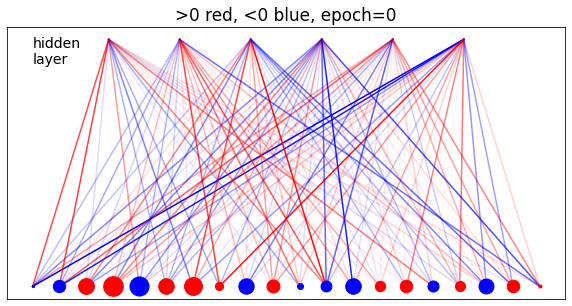

In [5]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(epoch, w, M, a, b):
    fig, ax = plt.subplots(1,1 , figsize=(10, 5))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    A=500.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.5,0.9,"hidden\nlayer")
    plt.show()
                  
plotgraph(0, rbm.w, M, rbm.a, rbm.b)

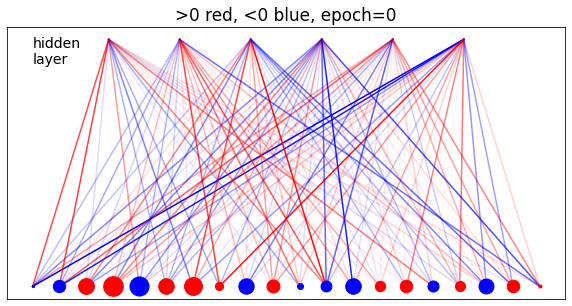

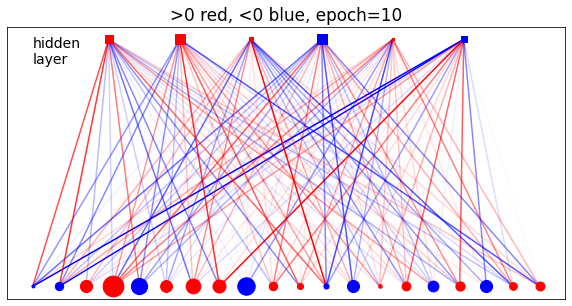

l_rate =  0.5


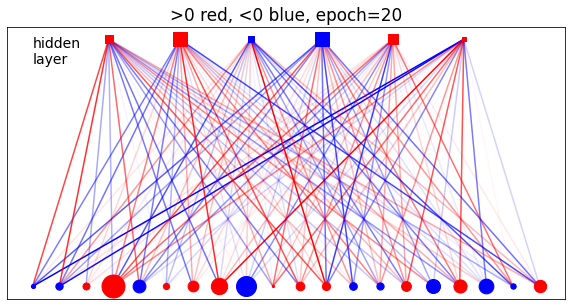

l_rate =  0.5


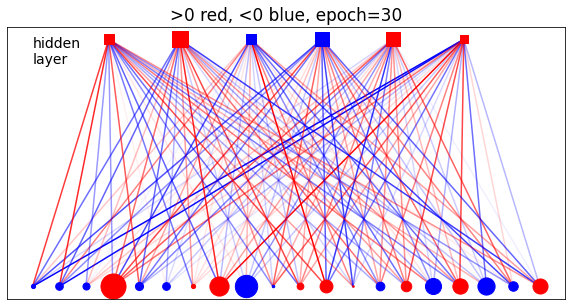

l_rate =  0.5


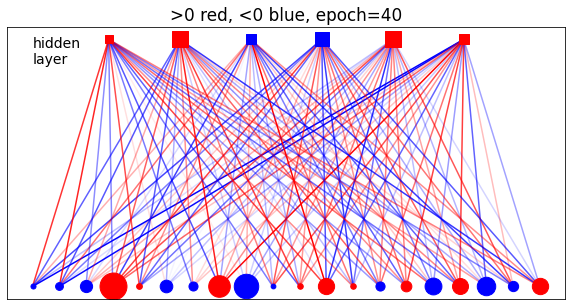

l_rate =  0.5


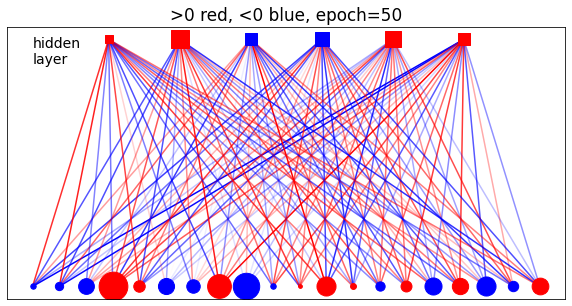

l_rate =  0.5


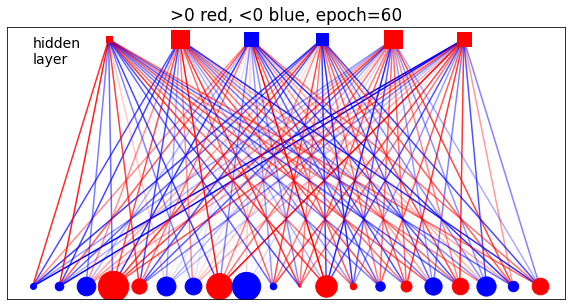

l_rate =  0.5


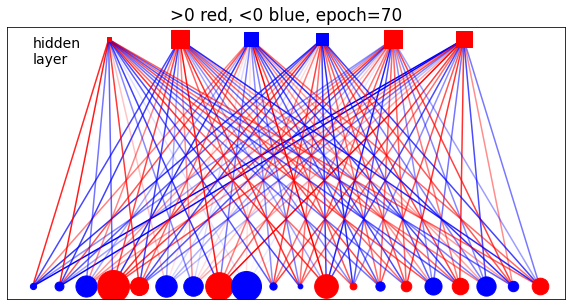

l_rate =  0.5


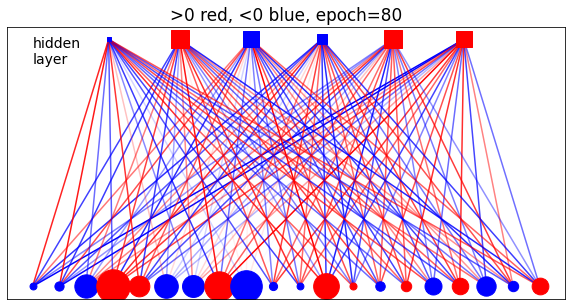

l_rate =  0.5


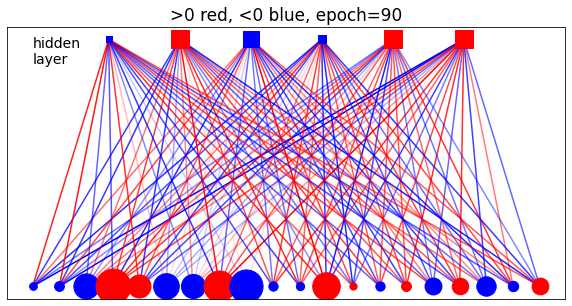

l_rate =  0.5


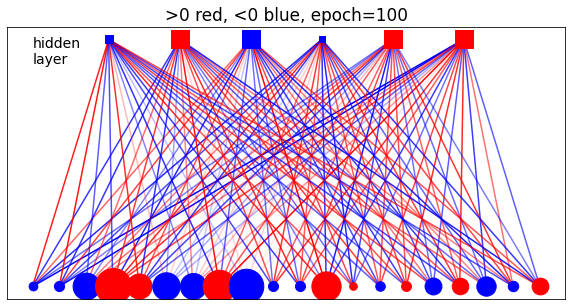

l_rate =  0.5


In [6]:
# random seed for reproducibility
np.random.seed(1)



plotgraph(0, rbm.w, M, rbm.a, rbm.b)

# learning rate
l_rate = 5e-1

# minibatch
mini, m = 500, 0




# train model
print('===================================================')
for epoch in range(100):
    # aggregate normalization of batch statistics and learning rate
    l_rate_m = l_rate / mini
    for k in range(N):
        if m==0:
            # initialize averages in miniblock
            rbm.init_avg()

        # positive CD phase: generating h 
        h = rbm.positive(v[k])
        # negative CD phase: generating fantasy vf
        vf = rbm.negative(h)
        # one more positive CD phase: generating fantasy h from fantasy vf 
        hf = rbm.positive(vf)

        rbm.update_vh(v[k], vf, h, hf)
        
    
        m += 1
        # minibatch
        if m==mini:
            # gradient of the likelihood: follow it along its positive direction
            # with a "vanilla" SGD
            rbm.RMSprop(l_rate_m, beta = 0.9)
            m=0
    
    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    #l_rate = l_rate / (0.01 * l_rate + 1)
    if epoch%10==9:
        plotgraph(epoch+1, rbm.w, M, rbm.a, rbm.b )
        print('l_rate = ',l_rate)

In [ ]:
from IPython.display import display_html 
import pandas as pd

ampl=40.

# original, non-reshuffled data in v0
v1 = np.zeros_like(v0)
for k in range(N):
    # positive CD phase: generating h 
    h = rbm.positive(v0[k],ampl)
    # negative CD phase: generating fantasy vf with low T == large GAP
    v1[k] = rbm.negative(h,ampl)
# difference between fantasy and data
diff = (v1 - v0)/2
str0 = fname+'_M'+str(M)+'-mini'+str(mini)
np.savetxt(str0+".fantasy", (v1+1)/2, fmt='%d',delimiter=' ')  
np.savetxt(str0+'.diff', diff, fmt='%d',delimiter=' ')  


def is_one(cell_value):
    color0 = 'background-color: gray; color: white'
    color1 = 'background-color: gold;'
    if type(cell_value) in [float, int]:
        if cell_value == 1:
            return color1
    return color0

N1=12
df0 = pd.DataFrame(v0[:N1])
df1 = pd.DataFrame(((v1[:N1]-vmin)/(1-vmin)).astype(int))

df0s = df0.style.set_table_attributes("style='display:inline'")
df1s = df1.style.set_table_attributes("style='display:inline'")
df0s.applymap(is_one)
df1s.applymap(is_one)
sty = [dict(selector="caption",props=[("font-size", "150%")])]
df0s.set_caption('Original').set_table_styles(sty)
df1s.set_caption('Denoised').set_table_styles(sty)

display_html(df0s._repr_html_()+df1s._repr_html_(), raw=True)
